## Tesla Stock Forecasting 
#### Year 2013 to 2023

#### Step 1: Import all libraries

In [105]:
# First import all Python libraries:

# Data Imports
import yfinance as yf
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from numpy import log
import warnings

# Visualization Imports
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import plotly.express as px
from scipy.stats import probplot
import plotly.io as pio
pio.renderers.default='notebook'

# Time-series libraries
import statsmodels.graphics.tsaplots as sgt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
from statsmodels.tsa.stattools import acf

#### Step 2: Get Tesla stock data from Ticker

In [106]:
# Tesla stock data using Symbol
SYMBOL = "TSLA"
columns = ['open', 'high', 'low', 'close', 'volume']

# Getting Tesla (TSLA) stock data
ticker = yf.Ticker(SYMBOL)

# End stock dates
start_date = "2013-01-01"
end_date = "2023-12-31"

# Pulling stock data 
df = ticker.history(start=start_date, end=end_date)
df.columns = df.columns.str.lower()

# Showing data
df.head()

open      high       low     close    volume  \
Date                                                                          
2013-01-02 00:00:00-05:00  2.333333  2.363333  2.314000  2.357333  17922000   
2013-01-03 00:00:00-05:00  2.345333  2.363333  2.316667  2.318000  11130000   
2013-01-04 00:00:00-05:00  2.320000  2.320000  2.261333  2.293333  10110000   
2013-01-07 00:00:00-05:00  2.320000  2.320000  2.260000  2.289333   6630000   
2013-01-08 00:00:00-05:00  2.300000  2.300000  2.207333  2.245333  19260000   

                           dividends  stock splits  
Date                                                
2013-01-02 00:00:00-05:00        0.0           0.0  
2013-01-03 00:00:00-05:00        0.0           0.0  
2013-01-04 00:00:00-05:00        0.0           0.0  
2013-01-07 00:00:00-05:00        0.0           0.0  
2013-01-08 00:00:00-05:00        0.0           0.0

In [107]:
# Data info
print('Data Info:')
df.info()

Data Info:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2768 entries, 2013-01-02 00:00:00-05:00 to 2023-12-29 00:00:00-05:00
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   open          2768 non-null   float64
 1   high          2768 non-null   float64
 2   low           2768 non-null   float64
 3   close         2768 non-null   float64
 4   volume        2768 non-null   int64  
 5   dividends     2768 non-null   float64
 6   stock splits  2768 non-null   float64
dtypes: float64(6), int64(1)
memory usage: 173.0 KB


Data has no missing values and is ready to be used for explorartory analysis.

#### Step 3: Exploratory analysis 
        (a) Candlestick Plot and moving average
        (b) Tesla stock splits
        (c) Percent change in stock price and volume
        (d) Q-Q Plot
        (e) ACF and PACF

(a) Candlestick plot with moving averages

In [108]:
# Overall, the function generates a candlestick chart for stock data, optionally including rolling averages, 
# and allows for customization of the plot appearance and time range selection.

def plot_candlestick(stock_df, name='', rolling_avg=None, fig_size=(1100, 700)):
    """
    Plot a candlestick chart for the given stock dataframe with optional rolling averages.
    
    Args:
        stock_df (pd.DataFrame): The stock data as a pandas DataFrame.
        name (str): The name of the stock, defaults to 'Tesla'.
        rolling_avg (list of int, optional): A list of integers for rolling average window sizes.
        fig_size (tuple): The figure size, defaults to (1100, 700).
    """
    # Copy df to avoid modifying the original data
    stock_data = stock_df.copy()
    
    # Creating plot
    fig = go.Figure(data=[go.Candlestick(x=stock_data.index,
        close=stock_data['close'], open=stock_data['open'], high=stock_data['high'], low=stock_data['low'], 
        name="Candlesticks", increasing_line_color='green', decreasing_line_color='red', line=dict(width=1)
                                        )])
    
    # In summary, this code block dynamically adds moving average lines to the candlestick plot based on the 
    # provided rolling average window sizes. Each moving average line is assigned a distinct color from the 
    # predefined list of colors.
    
    # Rolling averages if specified
    if rolling_avg:
        colors = ['rgba(0, 255, 255, 0.5)',   # cyan
                  'rgba(255, 255, 0, 0.5)',   # yellow
                  'rgba(255, 165, 0, 0.5)',   # orange
                  'rgba(255, 105, 180, 0.5)', # pink
                  'rgba(165, 42, 42, 0.5)',   # brown
                  'rgba(128, 128, 128, 0.5)', # gray
                  'rgba(128, 128, 0, 0.5)',   # olive
                  'rgba(0, 0, 255, 0.5)']     # blue
        
        for i, avg in enumerate(rolling_avg):
            color = colors[i % len(colors)]
            ma_column = f'{avg}-day MA'
            stock_data[ma_column] = stock_data['close'].rolling(window=avg).mean()

            # Moving average trace
            fig.add_trace(go.Scatter(x=stock_data.index, y=stock_data[ma_column],
                    mode='lines', name=f'{avg}-day Moving Average', line=dict(color=color)))

    # Layout updates
    fig.update_layout(title=f"{name} Stock Price - Candlestick Chart",
                      xaxis_title="Date", yaxis_title="Price",
                      width=fig_size[0], height=fig_size[1],
                      xaxis=dict(
                          rangeselector=dict(
                              buttons=list([
                                  dict(count=14, label="2w", step="day", stepmode="backward"),
                                  dict(count=1, label="1m", step="month", stepmode="backward"),
                                  dict(count=3, label="3m", step="month", stepmode="backward"),
                                  dict(count=6, label="6m", step="month", stepmode="backward"),
                                  dict(count=1, label="YTD", step="year", stepmode="todate"),
                                  dict(count=1, label="1y", step="year", stepmode="backward"),
                                  dict(count=2, label="2y", step="year", stepmode="backward"),
                                  dict(count=3, label="3y", step="year", stepmode="backward"),
                                  dict(count=5, label="5y", step="year", stepmode="backward"),
                                  dict(step="all")]),
                              bgcolor='pink',
                              font=dict(color='black'),
                              activecolor='lightgreen'))
                     )
    fig.show()

In [109]:
# General Tesla stocks
plot_candlestick(df, name=SYMBOL)

# With Moving averages
plot_candlestick(df, name=SYMBOL, rolling_avg=[20, 50, 200])

(b) Tesla stock splits

In [110]:
# This code generates a line plot using Plotly Express to visualize stock splits over time. 
# It customizes various aspects of the plot such as size, colors, and axis labels before displaying it.

# Plotting stock splits
fig = px.line(x=df.index, y=df['stock splits'], title=f'{SYMBOL} Stock Splits Over Time')
fig.update_layout(width=1100, height=500)
fig.update_traces(line=dict(color='cyan', width=3))
fig.update_xaxes(title_text='Date')
fig.update_yaxes(title_text='Stock Splits')
fig.show()

(c) Percent Change in stock price and volume

In [111]:
# Creating subplot
fig = make_subplots(rows=2, cols=2, column_widths=[0.7, 0.3],
                    vertical_spacing=0.1, horizontal_spacing=0.05,
                    subplot_titles=(f"{SYMBOL} - Percent Change over Time", f"{SYMBOL} Percent Change - Histogram",
                                    f"{SYMBOL} - Stock Volume over Time", f"{SYMBOL} Stock Volume - Histogram",))
# Percent Change Plot
percent_change = df['close'].pct_change() * 100
fig.add_trace(go.Scatter(x=df.index, y=percent_change, name='Percent Change', marker_color='darkorchid'), row=1, col=1)
fig.add_trace(go.Histogram(x=percent_change, nbinsx=50, name='Percent Change', marker_color='darkorchid'),  row=1, col=2)
fig.add_annotation(text=f"Mean: {percent_change.mean():.2f}%<br>Std Dev: {percent_change.std():.2f}%",
                   xref='x2', yref='y2', x=percent_change.mean(), y=5, showarrow=True)
# Volume Plot
fig.add_trace(go.Scatter(x=df.index, y=df['volume'], name='Volume', marker_color='darkcyan'), row=2, col=1)
fig.add_trace(go.Histogram(x=df['volume'], nbinsx=50, name='Daily Volume', marker_color='darkcyan'),  row=2, col=2)
fig.add_annotation(text=f"Mean: {df['volume'].mean():.2f}<br>Std Dev: {df['volume'].std():.2f}",
                   xref='x4', yref='y4', x=df['volume'].mean(), y=5, showarrow=True)

fig.update_layout(height=700, width=1100)
fig.show()

(d) Q-Q Plot

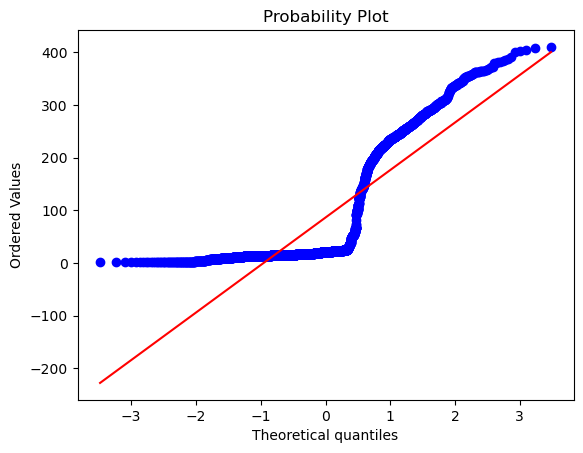

In [112]:
# the code generates a probability plot for the closing prices of a stock and displays it using Matplotlib.
probplot(df.close,plot=plt)
plt.show()

(e) Autocorrelation function (ACF) and Partial ACF

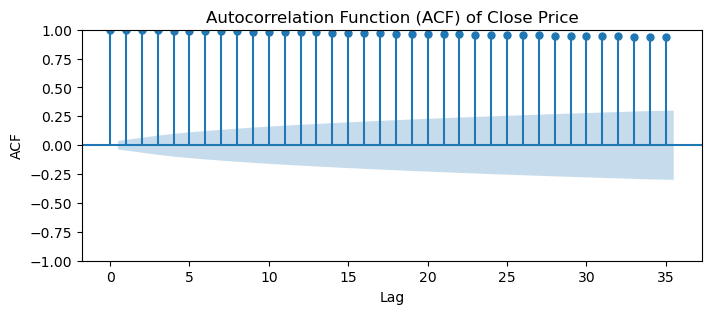

In [113]:
# ACF plot of close price
fig, ax = plt.subplots(figsize=(8, 3))  # Set the size of the figure and Axes
plot_acf(df.close, ax=ax)
plt.title('Autocorrelation Function (ACF) of Close Price')
plt.xlabel('Lag')
plt.ylabel('ACF')
plt.show()

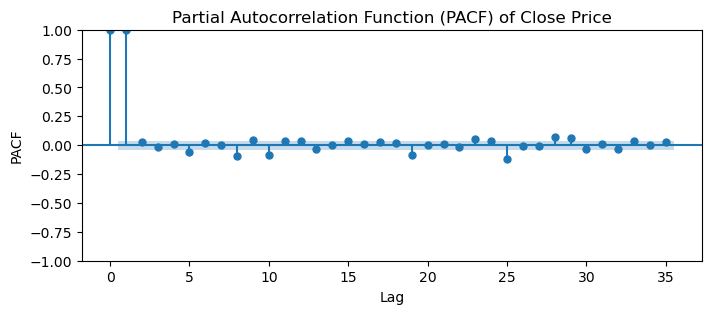

In [114]:
# PACF plot of close price
fig, ax = plt.subplots(figsize=(8, 3))  # Set the size of the figure and Axes
plot_pacf(df.close, method='ols', ax=ax)
plt.title('Partial Autocorrelation Function (PACF) of Close Price')
plt.xlabel('Lag')
plt.ylabel('PACF')
plt.show()

Here upto Lag-value 2, we have strong correlation. So we can keep lag value 2 for our further experiments. 

#### Step 4: ARIMA Time Series

In [115]:
result = adfuller(df.close.dropna(), autolag='AIC')
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
for key, value in result[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}')

ADF Statistic: -0.9272724690026403
p-value: 0.7788585955294782
Critial Values:
   1%, -3.4327397185476918
Critial Values:
   5%, -2.8625958054606793
Critial Values:
   10%, -2.5673320392686283


Since p-value is greater than 0.05, so we fail to reject the null hypothesis here. And accept the null-hypothesis that, the series is non-stationary.

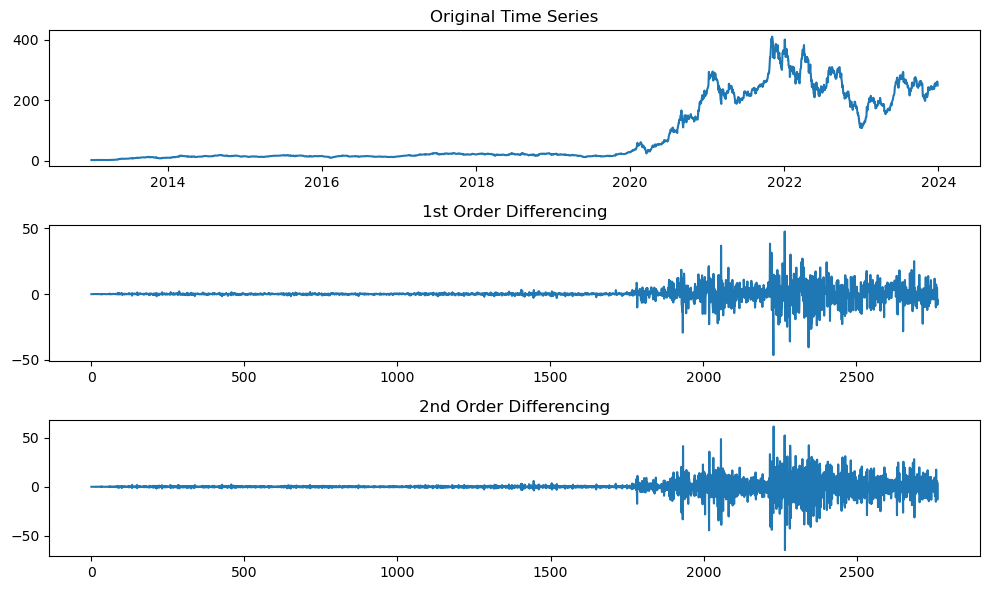

In [116]:
# find the order of differencing (d)

# Original time series
original_ts = df.close

# First difference
first_diff = np.diff(original_ts)

# Second difference
second_diff = np.diff(first_diff)

# Plotting
plt.figure(figsize=(10, 6))

plt.subplot(3, 1, 1)
plt.plot(original_ts)
plt.title('Original Time Series')

plt.subplot(3, 1, 2)
plt.plot(first_diff)
plt.title('1st Order Differencing')

plt.subplot(3, 1, 3)
plt.plot(second_diff)
plt.title('2nd Order Differencing')

plt.tight_layout()
plt.show()

Series is stationary after first difference.

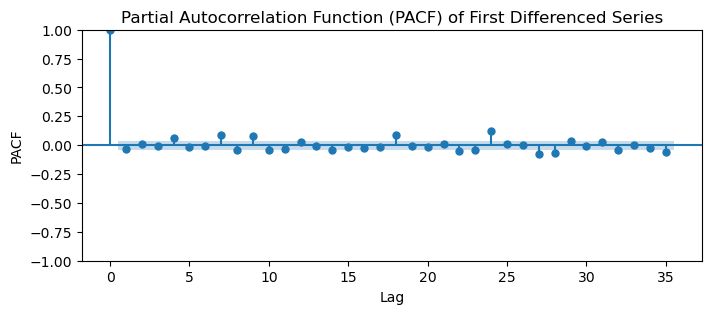

In [117]:
# find the order of the AR term (p)

# PACF plot of 1st differenced series
fig, ax = plt.subplots(figsize=(8, 3))  # Set the size of the figure and Axes
plot_pacf(first_diff, method='ols', ax=ax)
plt.title('Partial Autocorrelation Function (PACF) of First Differenced Series')
plt.xlabel('Lag')
plt.ylabel('PACF')
plt.show()

PACF of first differenced series has one lag outside the significant values. Hence, p=1, d=1 and q=1.

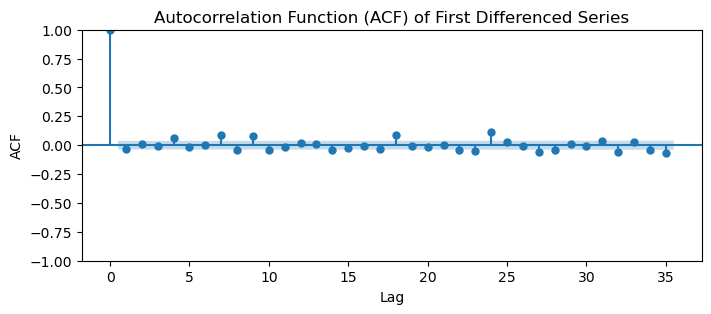

In [118]:
# find the order of the MA term (q)

# ACF plot of 1st differenced series
fig, ax = plt.subplots(figsize=(8, 3))  # Set the size of the figure and Axes
plot_acf(first_diff, ax=ax)
plt.title('Autocorrelation Function (ACF) of First Differenced Series')
plt.xlabel('Lag')
plt.ylabel('ACF')
plt.show()

ACF of first differenced series has one lag outside the significant values.

In [119]:
# this code segment initializes, fits, and summarizes an ARIMA(1,1,1) model on the closing prices of a stock time series data.

model = ARIMA(df.close , order = (1,1,1))
warnings.filterwarnings("ignore")
result = model.fit()
result.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  close   No. Observations:                 2768
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -8468.362
Date:                Sun, 05 May 2024   AIC                          16942.724
Time:                        22:39:31   BIC                          16960.500
Sample:                             0   HQIC                         16949.144
                               - 2768                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5961      0.158     -3.767      0.000      -0.906      -0.286
ma.L1          0.5637      0.163      3.450      0.001       0.243       0.884
sigma2        26.6569      0.245    108.962      0.000      26.177      27.136
===================================================================================
Ljung-Box (L1) (Q):                   0.03   Jarque-Bera (JB):             26898.17
Prob(Q):                              0.87   Prob(JB):                         0.00
Heteroskedasticity (H):             554.03   Skew:                            -0.15
Prob(H) (two-sided):                  0.00   Kurtosis:                        18.27
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

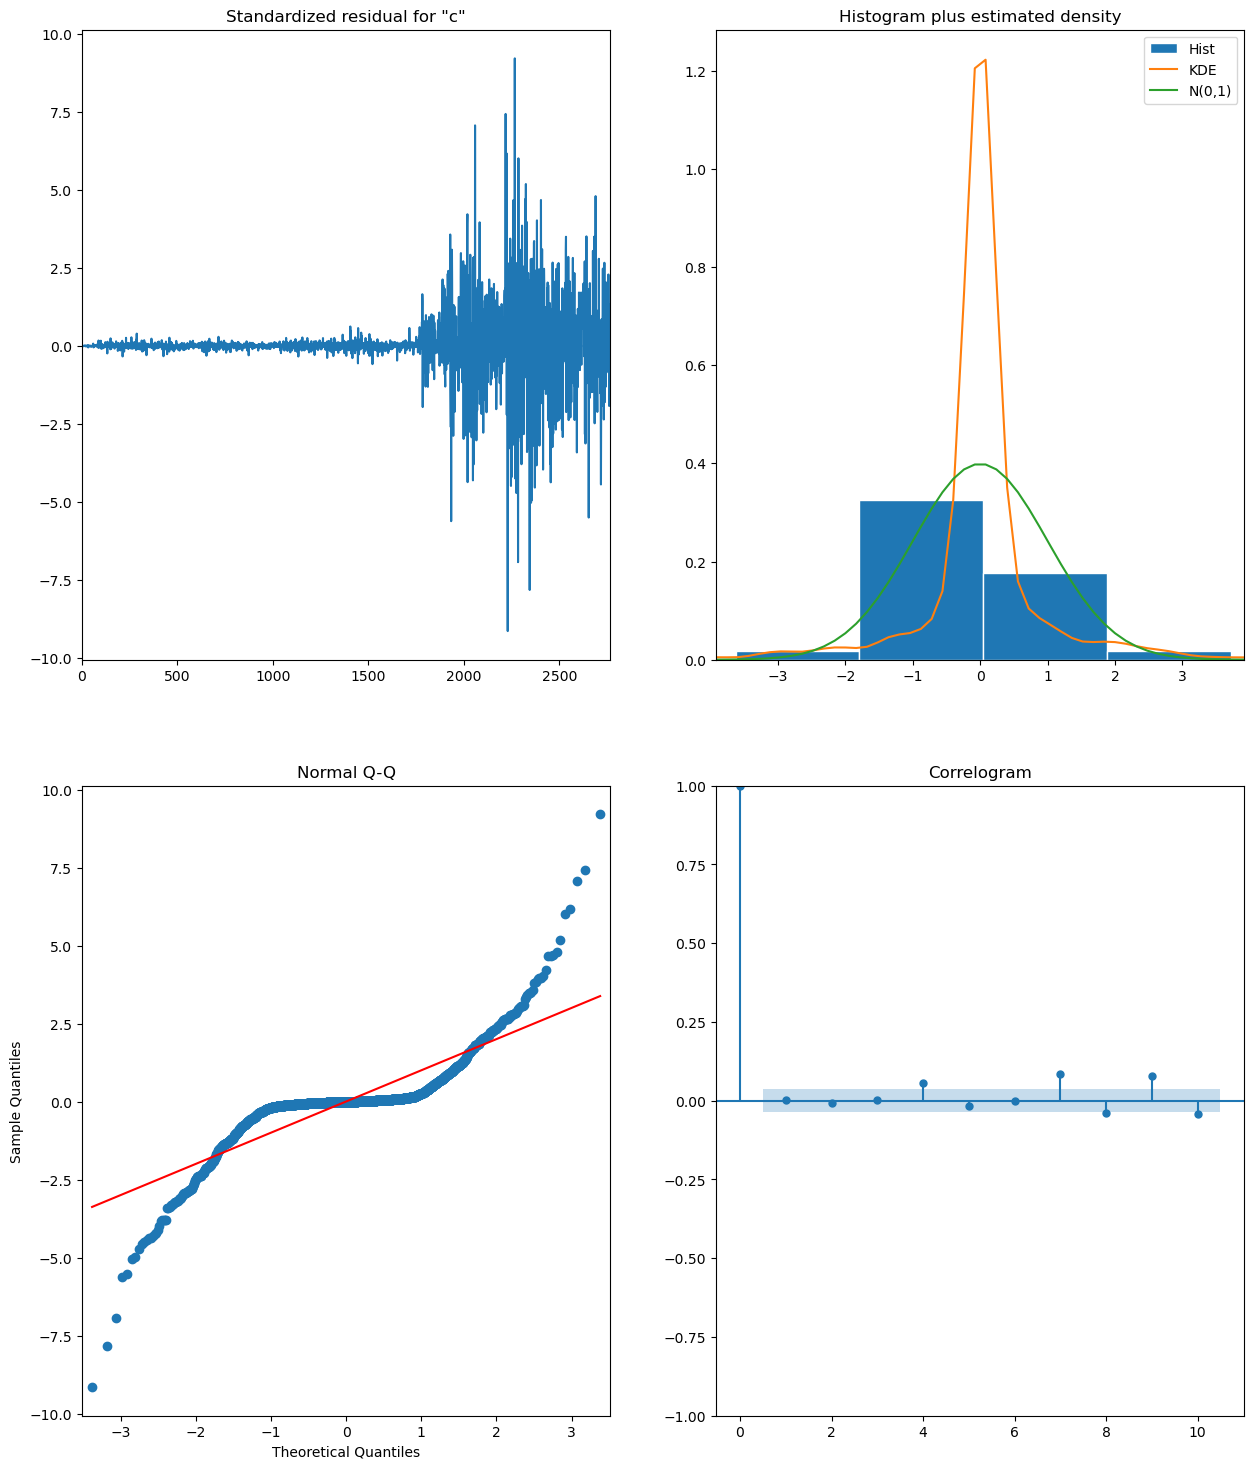

In [120]:
# plot model residual results
result.plot_diagnostics(figsize=(15, 18))
plt.show()

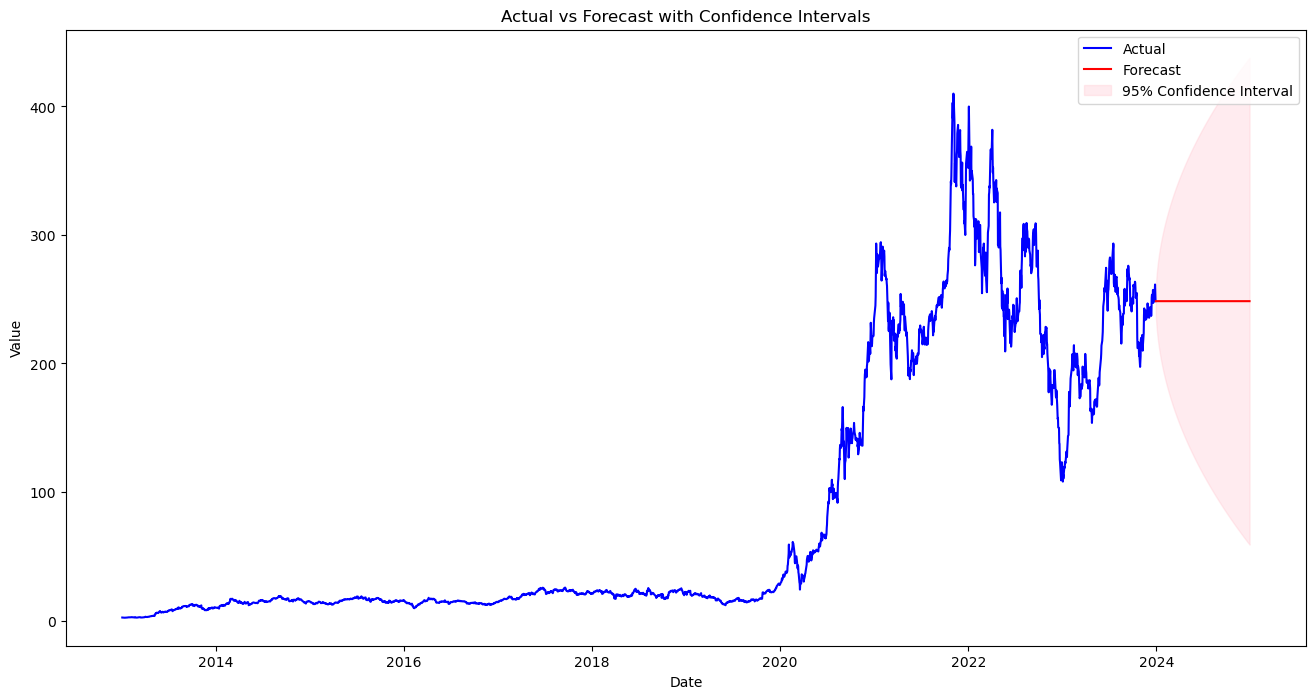

In [121]:
# predict stock price for next 365 days
forecast_steps = 365
forecast_results = result.get_forecast(steps=forecast_steps)

# Extract forecast values and confidence intervals
forecast_values = forecast_results.predicted_mean
confidence_intervals = forecast_results.conf_int()

# Generate the forecast index as a date range
last_date = df.index[-1]
forecast_index = pd.date_range(start=last_date, periods=forecast_steps+1, closed='right')[0:]

# Plot actual vs forecast with confidence intervals
plt.figure(figsize=(16, 8))
plt.plot(df.index, df['close'], label='Actual', color='blue')  # Plot actual values
plt.plot(forecast_index, forecast_values, label='Forecast', color='red')  # Plot forecasted values
plt.fill_between(forecast_index, confidence_intervals.iloc[:, 0], confidence_intervals.iloc[:, 1], color='pink', alpha=0.3, label='95% Confidence Interval')  # Plot confidence intervals

plt.title('Actual vs Forecast with Confidence Intervals')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.show()

In [122]:
# Optimal ARIMA model using out-of-time cross validation

# Create Training and Test
train = df.close[:2000]
test = df.close[2000:]

# Build Model - we will build the ARIMA model on training dataset, forecast and plot it.
model = ARIMA(train, order=(1, 1, 1))  
fitted = model.fit()
fitted.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  close   No. Observations:                 2000
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -4063.676
Date:                Sun, 05 May 2024   AIC                           8133.352
Time:                        22:39:33   BIC                           8150.153
Sample:                             0   HQIC                          8139.521
                               - 2000                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6684      0.088      7.628      0.000       0.497       0.840
ma.L1         -0.6391      0.090     -7.071      0.000      -0.816      -0.462
sigma2         3.4138      0.020    168.476      0.000       3.374       3.454
===================================================================================
Ljung-Box (L1) (Q):                   1.39   Jarque-Bera (JB):            271952.76
Prob(Q):                              0.24   Prob(JB):                         0.00
Heteroskedasticity (H):              69.91   Skew:                            -0.58
Prob(H) (two-sided):                  0.00   Kurtosis:                        60.13
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

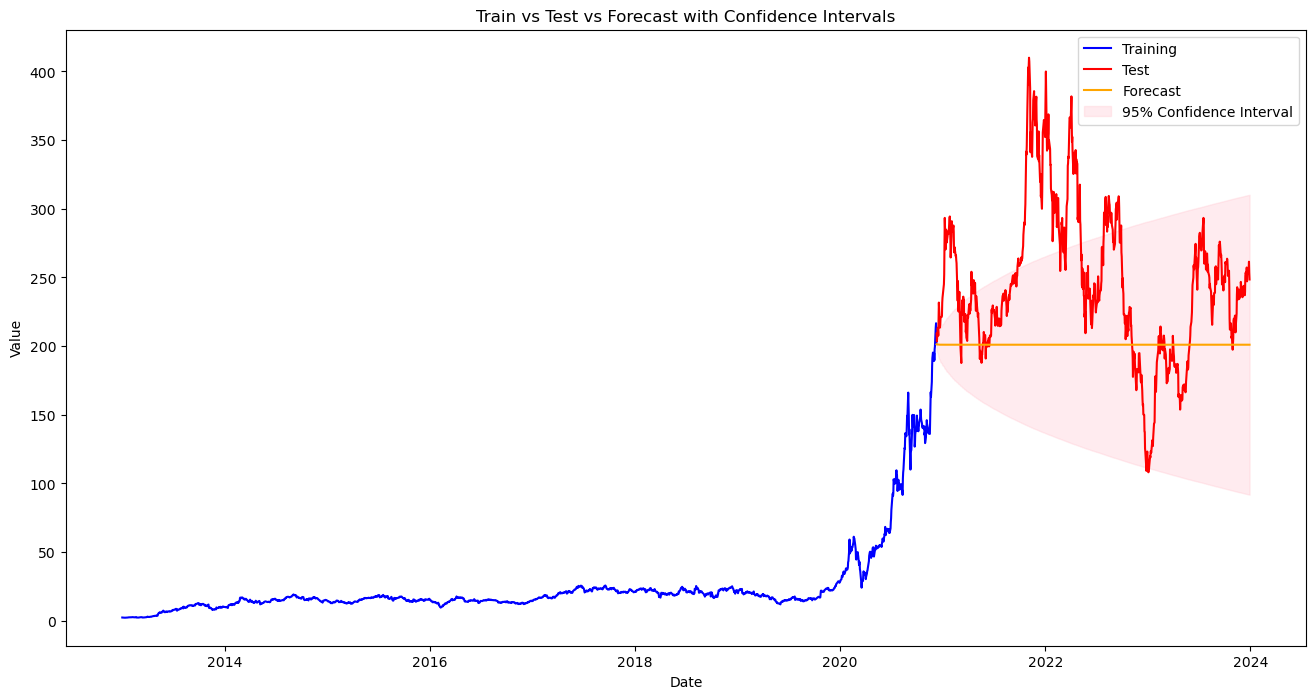

In [123]:
# forecast test values
forecast_steps = len(test)
forecast_results = fitted.get_forecast(steps=forecast_steps)

# Extract forecast values and confidence intervals
forecast_values = forecast_results.predicted_mean
confidence_intervals = forecast_results.conf_int()

# Plot actual vs forecast with confidence intervals
plt.figure(figsize=(16, 8))
plt.plot(train.index, train, label='Training', color='blue')  # Plot train data
plt.plot(test.index, test, label='Test', color='red')  # Plot test data
plt.plot(test.index, forecast_values, label='Forecast', color='orange')  # Plot forecasted values
plt.fill_between(test.index, confidence_intervals.iloc[:, 0], confidence_intervals.iloc[:, 1], color='pink', alpha=0.3, label='95% Confidence Interval')  # Plot confidence intervals

plt.title('Train vs Test vs Forecast with Confidence Intervals')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.show()

In [124]:
# Accuracy metrics
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    corr = np.corrcoef(forecast, actual)[0,1]   # corr
    mins = np.amin(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    maxs = np.amax(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    minmax = 1 - np.mean(mins/maxs)             # minmax
    acf1 = acf(forecast_values-test)[1]                      # ACF1
    return({'mape':mape, 'me':me, 'mae': mae, 
            'mpe': mpe, 'rmse':rmse, 'acf1':acf1, 
            'corr':corr, 'minmax':minmax})

forecast_accuracy(forecast_values, test.values)

{'mape': 0.21216588564109076,
 'me': -45.35750441313763,
 'mae': 55.999036828519,
 'mpe': -0.139199699414388,
 'rmse': 71.41645599017059,
 'acf1': nan,
 'corr': -0.053228764759167047,
 'minmax': 0.2021556792229946}

#### Step 5: Exponential Smoothing

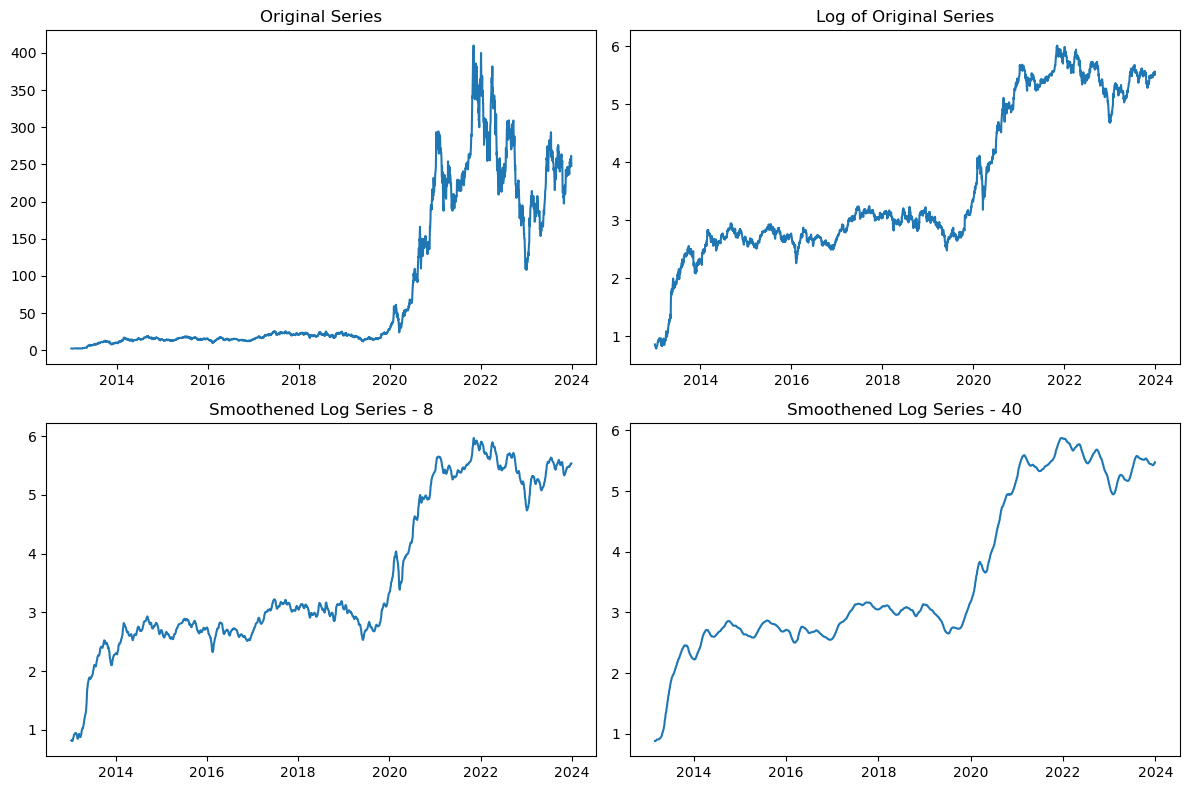

In [125]:
# plot log and smoothened series of the original close price series
fig, axs = plt.subplots(2, 2, figsize=(12, 8))

# Plot data1 on the first subplot (top-left)
axs[0, 0].plot(df.close)
axs[0, 0].set_title('Original Series')

# Plot data2 on the second subplot (top-right)
LogTeslaStock = log(df.close)
axs[0, 1].plot(LogTeslaStock)
axs[0, 1].set_title('Log of Original Series')

# Plot data3 on the third subplot (bottom-left)
LogTeslaStockSMA = LogTeslaStock.rolling(window=8).mean()
axs[1, 0].plot(LogTeslaStockSMA)
axs[1, 0].set_title('Smoothened Log Series - 8')

# Plot data4 on the fourth subplot (bottom-right)
LogTeslaStockSMA40 = LogTeslaStock.rolling(window=40).mean()
axs[1, 1].plot(LogTeslaStockSMA40)
axs[1, 1].set_title('Smoothened Log Series - 40')

# Adjust layout to prevent overlapping
plt.tight_layout()

# Show the plot
plt.show()

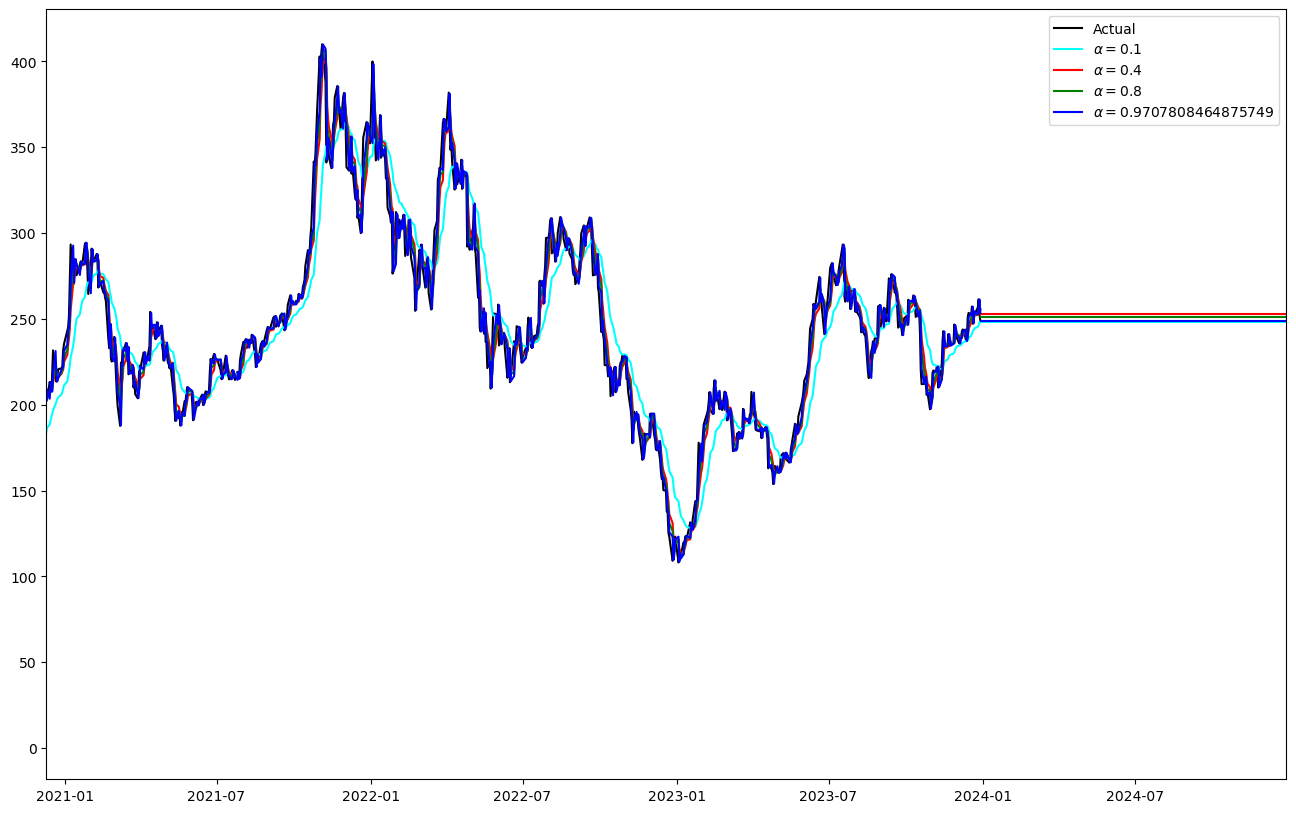

In [126]:
stock_data = df.close
forecast_timestep = 365

# Generate the forecast index as a date range
last_date = df.index[-1]
forecast_index = pd.date_range(start=last_date, periods=forecast_timestep+1, closed='right')[0:]

fit_1 = SimpleExpSmoothing(stock_data, initialization_method="heuristic").fit(smoothing_level=0.1,optimized=False)
forecast1 = fit_1.forecast(forecast_timestep).rename(r'$\alpha=0.1$')
fit_2 = SimpleExpSmoothing(stock_data, initialization_method="heuristic").fit(smoothing_level=0.4,optimized=False)
forecast2 = fit_2.forecast(forecast_timestep).rename(r'$\alpha=0.4$')
fit_3 = SimpleExpSmoothing(stock_data, initialization_method="heuristic").fit(smoothing_level=0.6,optimized=False)
forecast3 = fit_3.forecast(forecast_timestep).rename(r'$\alpha=0.8$')
fit_4 = SimpleExpSmoothing(stock_data, initialization_method="estimated").fit()
forecast4 = fit_4.forecast(forecast_timestep).rename(r'$\alpha=%s$'%fit_4.model.params['smoothing_level'])

plt.figure(figsize=(16,10))
line1, = plt.plot(df.index, stock_data, color='black')
plt.plot(df.index, fit_1.fittedvalues, color='cyan')
line2, = plt.plot(forecast_index, forecast1, color='cyan')
plt.plot(df.index, fit_2.fittedvalues, color='red')
line3, = plt.plot(forecast_index, forecast2, color='red')
plt.plot(df.index, fit_3.fittedvalues, color='green')
line4, = plt.plot(forecast_index, forecast3, color='green')
plt.plot(df.index, fit_4.fittedvalues, color='blue')
line5, = plt.plot(forecast_index, forecast4, color='blue')

x_min = df.index[2000]
x_max = df.index[-1] + pd.Timedelta(days=365)
plt.xlim(x_min, x_max)

plt.legend([line1, line2, line3, line4, line5], ['Actual', forecast1.name, forecast2.name, forecast3.name, forecast4.name])
plt.show()

In [127]:
# Single Exponential Smoothing - model results with alpha=0.1
fit_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                       SimpleExpSmoothing Model Results                       
==============================================================================
Dep. Variable:                  close   No. Observations:                 2768
Model:             SimpleExpSmoothing   SSE                         412631.300
Optimized:                      False   AIC                          13856.261
Trend:                           None   BIC                          13868.112
Seasonal:                        None   AICC                         13856.275
Seasonal Periods:                None   Date:                 Sun, 05 May 2024
Box-Cox:                        False   Time:                         22:39:38
Box-Cox Coeff.:                  None                                         
==============================================================================
                       coeff                 code              optimized      
------------------------------------------------------------------------------
smoothing_level            0.1000000                alpha                False
initial_level              2.3399998                  l.0                False
------------------------------------------------------------------------------
"""

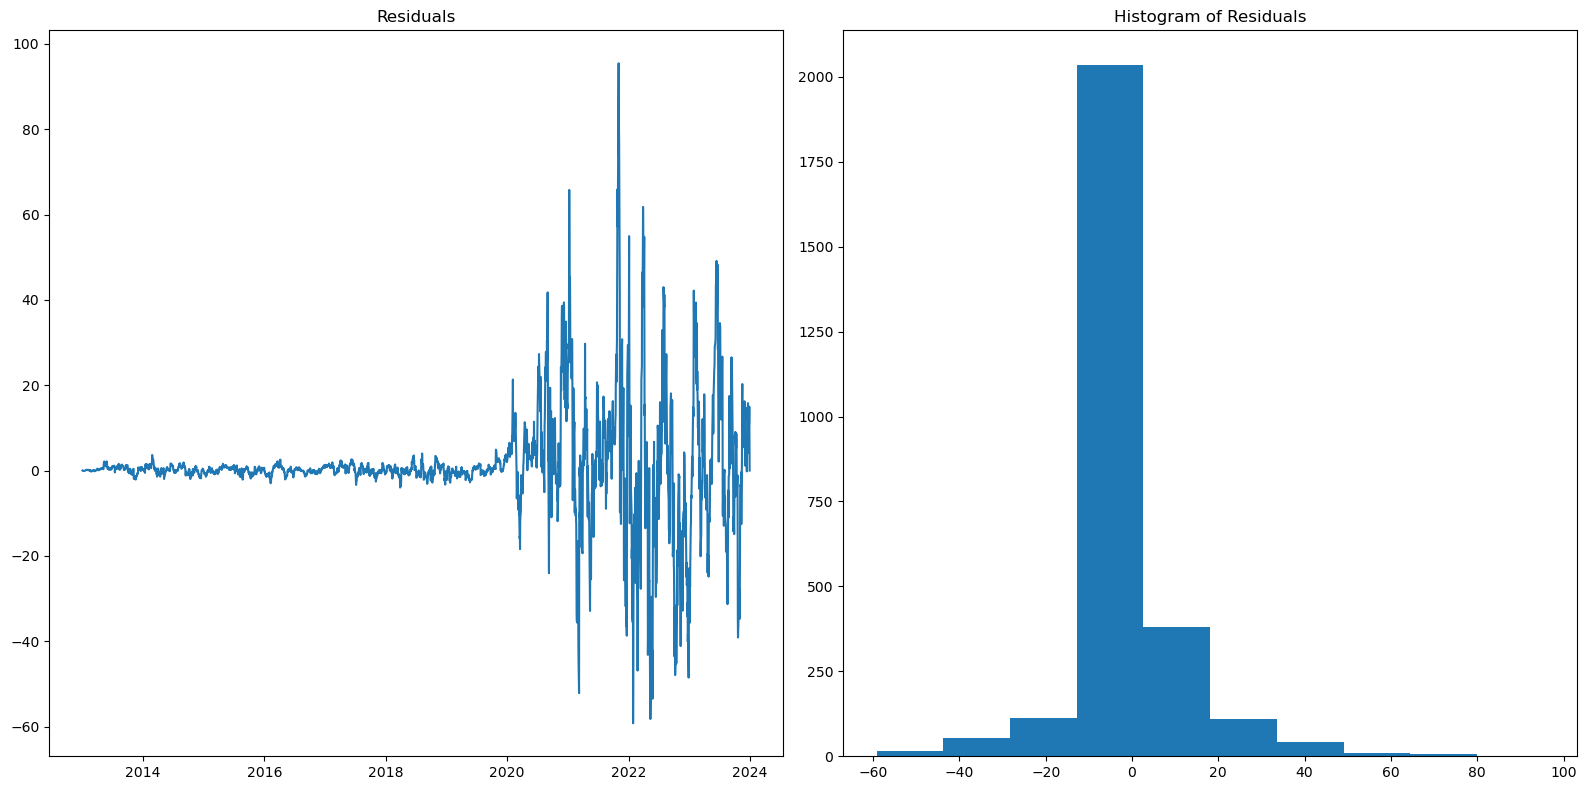

In [128]:
# plot model residual results
# Calculate residuals
residuals = stock_data - fit_1.fittedvalues

# Plotting diagnostics
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# Residuals plot
axes[0].plot(residuals)
axes[0].set_title('Residuals')

# Histogram of residuals
axes[1].hist(residuals, bins=10)
axes[1].set_title('Histogram of Residuals')

plt.tight_layout()
plt.show()

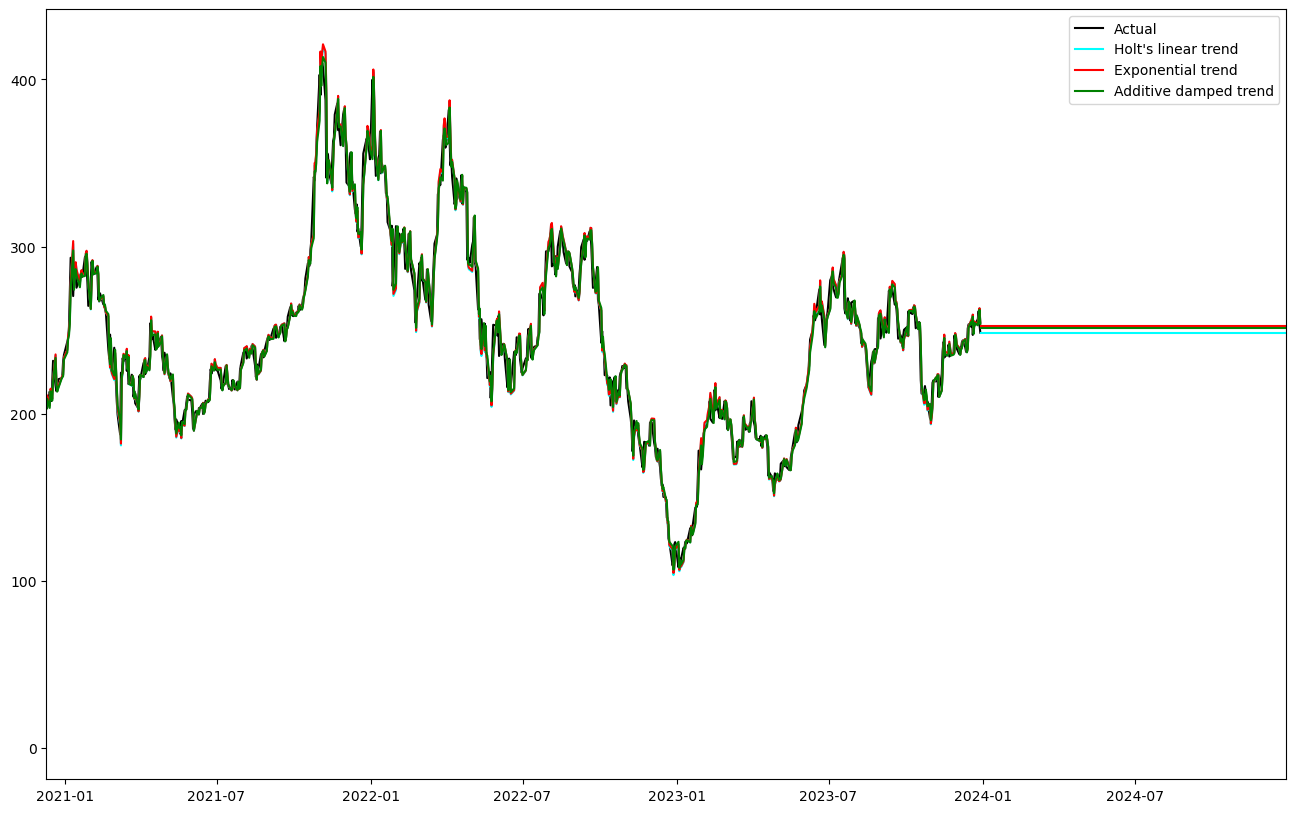

In [57]:
# Holt Exponential Smoothing

fit1 = Holt(stock_data, initialization_method="estimated").fit(smoothing_level=0.9, smoothing_trend=0.2, optimized=False)
fcast1 = fit1.forecast(forecast_timestep).rename("Holt's linear trend")

fit2 = Holt(stock_data, exponential=True, initialization_method="estimated").fit(smoothing_level=0.9, smoothing_trend=0.2, optimized=False)
fcast2 = fit2.forecast(forecast_timestep).rename("Exponential trend")

fit3 = Holt(stock_data, damped_trend=True, initialization_method="estimated").fit(smoothing_level=0.9, smoothing_trend=0.2)
fcast3 = fit3.forecast(forecast_timestep).rename("Additive damped trend")


plt.figure(figsize=(16,10))
line1, = plt.plot(df.index, stock_data, color='black')
plt.plot(df.index, fit1.fittedvalues, color='cyan')
line2, = plt.plot(forecast_index, forecast1, color='cyan')
plt.plot(df.index, fit2.fittedvalues, color='red')
line3, = plt.plot(forecast_index, forecast2, color='red')
plt.plot(df.index, fit3.fittedvalues, color='green')
line4, = plt.plot(forecast_index, forecast3, color='green')

x_min = df.index[2000]
x_max = df.index[-1] + pd.Timedelta(days=365)
plt.xlim(x_min, x_max)

plt.legend([line1, line2, line3, line4], ['Actual', fcast1.name, fcast2.name, fcast3.name])
plt.show()

In [58]:
# Holt Exponential Smoothing - model results with alpha=0.9 and beta=0.2
fit1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              Holt Model Results                              
==============================================================================
Dep. Variable:                  close   No. Observations:                 2768
Model:                           Holt   SSE                          80232.567
Optimized:                      False   AIC                           9327.315
Trend:                       Additive   BIC                           9351.018
Seasonal:                        None   AICC                          9327.345
Seasonal Periods:                None   Date:                 Sun, 05 May 2024
Box-Cox:                        False   Time:                         18:29:32
Box-Cox Coeff.:                  None                                         
==============================================================================
                       coeff                 code              optimized      
------------------------------------------------------------------------------
smoothing_level            0.9000000                alpha                False
smoothing_trend            0.2000000                 beta                False
initial_level              2.3399998                  l.0                False
initial_trend             -0.0135879                  b.0                False
------------------------------------------------------------------------------
"""

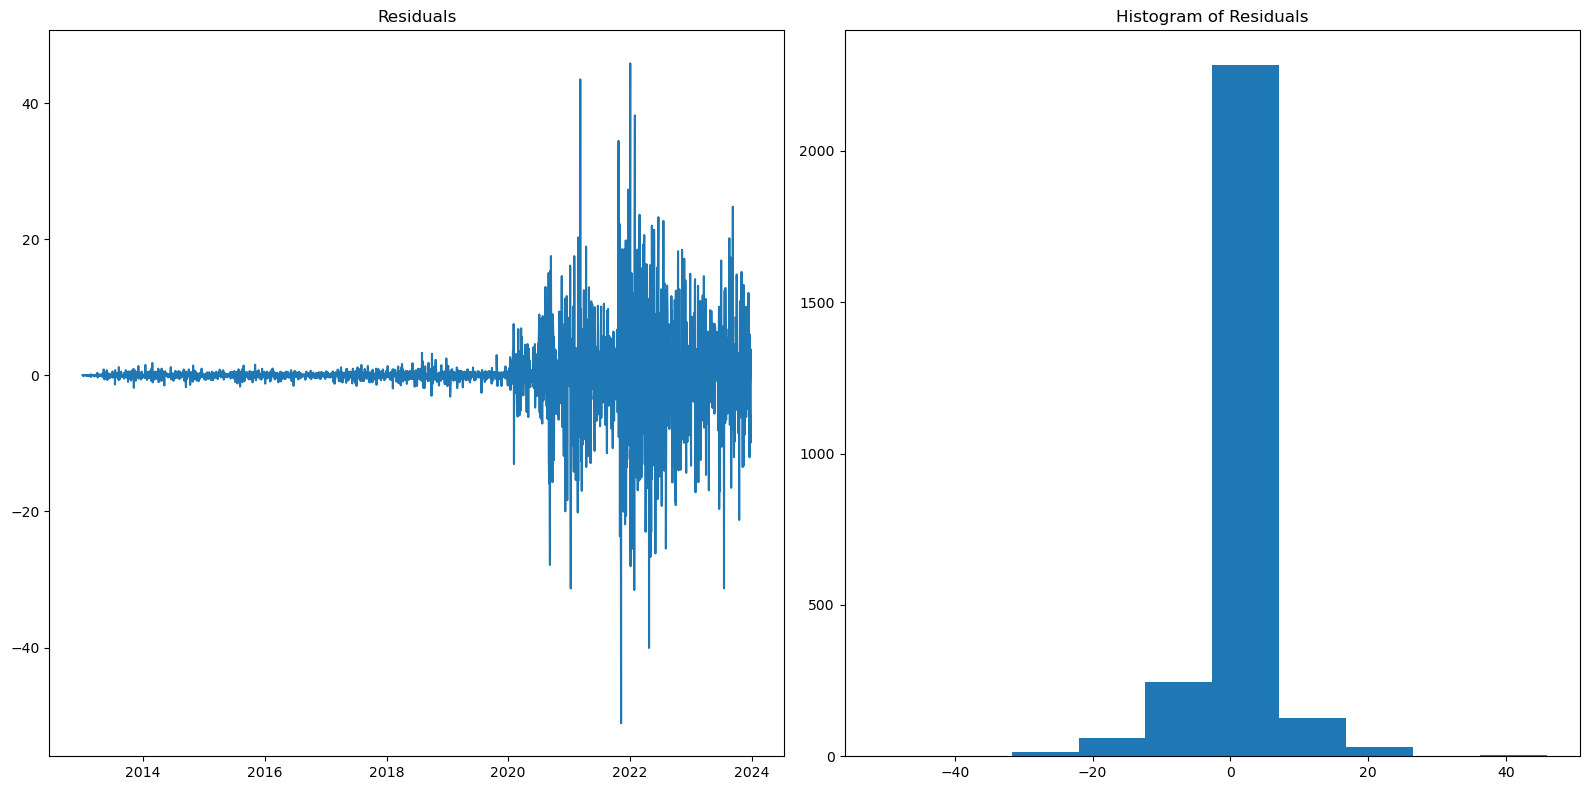

In [60]:
# plot model residual results
# Calculate residuals
residuals = stock_data - fit1.fittedvalues

# Plotting diagnostics
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# Residuals plot
axes[0].plot(residuals)
axes[0].set_title('Residuals')

# Histogram of residuals
axes[1].hist(residuals, bins=10)
axes[1].set_title('Histogram of Residuals')

plt.tight_layout()
plt.show()